# Import

In [1]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import concatenate_datasets, load_dataset
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datasets
from datasets import Dataset, Value, ClassLabel, Features
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
from transformers import DataCollatorWithPadding
import optuna
from huggingface_hub import notebook_login

# Datasets

In [3]:
# lables value

# 2 = positive
# 1 = neutral
# 0 = negative

In [4]:
dataset_tweet= load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
dataset_tweet

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 870
    })
})

In [5]:
dataset_tweet_cc = concatenate_datasets([dataset_tweet['train'], dataset_tweet['validation'],dataset_tweet['test']])
dataset_tweet_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 3033
})

In [6]:
dataset_mteb = load_dataset("mteb/tweet_sentiment_extraction")

In [7]:
dataset_mteb

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [8]:
dataset_mteb_cc = concatenate_datasets([dataset_mteb['train'], dataset_mteb['test']])
dataset_mteb_cc

Dataset({
    features: ['id', 'text', 'label', 'label_text'],
    num_rows: 31015
})

In [9]:
dataset_mteb_cc=dataset_mteb_cc.remove_columns('label_text')
dataset_mteb_cc=dataset_mteb_cc.remove_columns('id')

dataset_mteb_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 31015
})

In [10]:
dataset_tweet_cc.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [11]:
dataset_mteb_cc.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [12]:
features = dataset_mteb_cc.features.copy()
features["label"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["label"] = [dataset_mteb_cc for dataset_mteb_cc in batch["label"]]
    return batch
label_dataset = dataset_mteb_cc.map(adjust_labels, batched=True, features=features)

In [13]:
label_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [14]:
dataset_cc = concatenate_datasets([label_dataset, dataset_tweet_cc])
dataset_cc

Dataset({
    features: ['text', 'label'],
    num_rows: 34048
})

## test dataset

In [15]:
notebook_login()

In [16]:
raw_dataset=load_dataset("HFFErica/sentimentanalysis")
print(raw_dataset)

DatasetDict({
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1700
    })
})


In [17]:
features = raw_dataset["test"].features.copy()
features["labels_three_2p"] = ClassLabel(names=['negative', 'neutral', 'positive'])
def adjust_labels(batch):
    batch["labels_three_2p"] = [test for test in batch["labels_three_2p"]]
    return batch
label_dataset = raw_dataset.map(adjust_labels, batched=True, features=features)

In [18]:
label_dataset["test"].features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [19]:
label_dataset_split = label_dataset['test'].train_test_split(test_size=0.4112, stratify_by_column="labels_three_2p")
label_dataset_split

DatasetDict({
    train: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
        num_rows: 700
    })
})

### test dataset groups

In [20]:
test_dataset=label_dataset_split['train']
test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})

In [21]:
pretrain_test_dataset=label_dataset_split['test']
pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 700
})

In [22]:
test_dataset.features

{'sequence': Value(dtype='string', id=None),
 'labels': Value(dtype='string', id=None),
 'labels_five': Value(dtype='int64', id=None),
 'labels_three': Value(dtype='int64', id=None),
 'labels_three_2p': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

### Pretrain merge

In [23]:
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_five')
pretrain_test_dataset=pretrain_test_dataset.remove_columns('labels_three')

pretrain_test_dataset

Dataset({
    features: ['sequence', 'labels_three_2p'],
    num_rows: 700
})

In [24]:
pretrain_test_dataset=pretrain_test_dataset.rename_column("sequence", "text")
pretrain_test_dataset=pretrain_test_dataset.rename_column("labels_three_2p", "label")

pretrain_test_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 700
})

In [25]:
dataset_ccc = concatenate_datasets([dataset_cc,pretrain_test_dataset])
dataset_ccc

Dataset({
    features: ['text', 'label'],
    num_rows: 34748
})

## split 

In [26]:
ds = pretrain_test_dataset.train_test_split(test_size=0.2, stratify_by_column="label")
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 560
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 140
    })
})

In [27]:
train_dataset = ds['train']
validation_dataset = ds['test']
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 560
})
Dataset({
    features: ['text', 'label'],
    num_rows: 140
})


## label balance

<Axes: ylabel='count'>

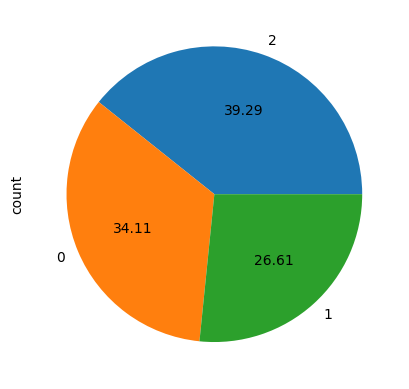

In [28]:
df_train = train_dataset.to_pandas()
df_train.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

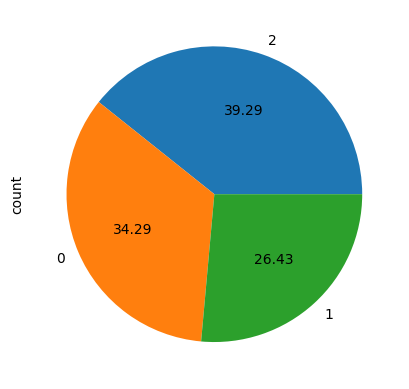

In [29]:
df_validation = validation_dataset.to_pandas()
df_validation.label.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

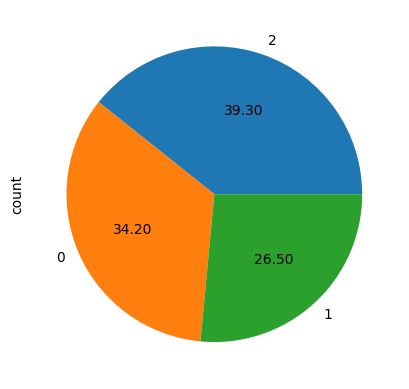

In [30]:
df_test = test_dataset.to_pandas()
df_test.labels_three_2p.value_counts().plot(kind = 'pie', autopct="%.2f")

<Axes: ylabel='count'>

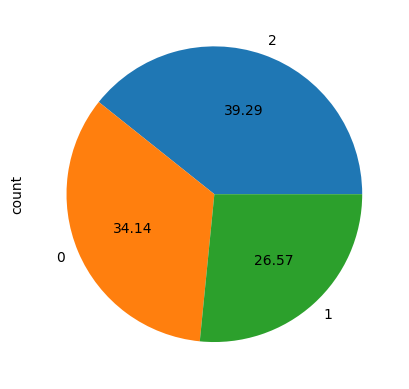

In [31]:
df_pretest = pretrain_test_dataset.to_pandas()
df_pretest.label.value_counts().plot(kind = 'pie', autopct="%.2f")

## Map

In [32]:
print(train_dataset)
print(validation_dataset)
print(test_dataset)
print(pretrain_test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 560
})
Dataset({
    features: ['text', 'label'],
    num_rows: 140
})
Dataset({
    features: ['sequence', 'labels', 'labels_five', 'labels_three', 'labels_three_2p'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 700
})


In [33]:
train_dataset = train_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
validation_dataset = validation_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)
test_dataset = test_dataset.map(lambda examples: {'labels': examples['labels_three_2p']}, batched=True)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

# Model 

In [34]:
model_id="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"



# label2id = {"positive": 2, "neutral": 1,"negative":0}

# 2 = positive
# 1 = neutral
# 0 = negative

model = AutoModelForSequenceClassification.from_pretrained(model_id, 
                                                           num_labels=train_dataset.features["label"].num_classes,
#                                                            id2label=label2id,
                                                          ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
model.config

RobertaConfig {
  "_name_or_path": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.34.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [35]:
MAX_LENGTH = 256
train_dataset = train_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
validation_dataset = validation_dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
test_dataset = test_dataset.map(lambda e: tokenizer(e['sequence'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/140 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [36]:
train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None),
 'labels': Value(dtype='int64', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [37]:
# train_dataset.set_format(type='torch', columns=['input_ids','token_type_ids', 'attention_mask', 'labels'])
# validation_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
# test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids',  'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [38]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# hyperparameter search

In [39]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_id, return_dict=True)

In [40]:
training_args = TrainingArguments("test",  eval_steps=500, disable_tqdm=True, do_eval=True, evaluation_strategy='steps')
trainer = Trainer(
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer),
    train_dataset=train_dataset, 
    eval_dataset=validation_dataset, 
    model_init=model_init,
    compute_metrics=compute_metrics,
)

In [41]:
def my_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 5),
#         "seed": trial.suggest_int("seed", 1, 40),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 24, 32, 36, 40, 48,56, 64,72]),
    }

In [42]:
trainer.hyperparameter_search(direction="maximize", hp_space=my_hp_space)

[I 2023-12-06 10:49:53,180] A new study created in memory with name: no-name-fc8d3076-b1b0-408e-a950-2e691b147081
wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 92.5176, 'train_samples_per_second': 6.053, 'train_steps_per_second': 0.086, 'train_loss': 4.008127212524414, 'epoch': 1.0}


[I 2023-12-06 10:51:33,492] Trial 0 finished with value: 1.7950635023153205 and parameters: {'learning_rate': 1.4053358298534841e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 72}. Best is trial 0 with value: 1.7950635023153205.


{'eval_loss': 3.9483838081359863, 'eval_accuracy': 0.40714285714285714, 'eval_f1': 0.3987822256769011, 'eval_precision': 0.5561224489795918, 'eval_recall': 0.43301597051597057, 'eval_runtime': 4.9751, 'eval_samples_per_second': 28.14, 'eval_steps_per_second': 3.618, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 127.3059, 'train_samples_per_second': 4.399, 'train_steps_per_second': 0.063, 'train_loss': 3.904021739959717, 'epoch': 1.0}


[I 2023-12-06 10:53:42,492] Trial 1 finished with value: 1.7532021663447612 and parameters: {'learning_rate': 1.9710545153868293e-06, 'num_train_epochs': 1, 'per_device_train_batch_size': 72}. Best is trial 0 with value: 1.7950635023153205.


{'eval_loss': 3.7580645084381104, 'eval_accuracy': 0.4, 'eval_f1': 0.39357945546992806, 'eval_precision': 0.5385641523162746, 'eval_recall': 0.4210585585585586, 'eval_runtime': 0.4319, 'eval_samples_per_second': 324.176, 'eval_steps_per_second': 41.68, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 60.5523, 'train_samples_per_second': 18.496, 'train_steps_per_second': 0.595, 'train_loss': 1.1625952190823026, 'epoch': 2.0}


[I 2023-12-06 10:54:44,744] Trial 2 finished with value: 2.6485603559132227 and parameters: {'learning_rate': 1.7083465018076416e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 0.7850106358528137, 'eval_accuracy': 0.6857142857142857, 'eval_f1': 0.6512633668058888, 'eval_precision': 0.6575525368628817, 'eval_recall': 0.6540301665301665, 'eval_runtime': 0.4224, 'eval_samples_per_second': 331.459, 'eval_steps_per_second': 42.616, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 60.3276, 'train_samples_per_second': 18.565, 'train_steps_per_second': 0.53, 'train_loss': 2.952314853668213, 'epoch': 2.0}


[I 2023-12-06 10:55:46,516] Trial 3 finished with value: 2.132967842398003 and parameters: {'learning_rate': 2.5711375695913756e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 36}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 2.343498945236206, 'eval_accuracy': 0.5428571428571428, 'eval_f1': 0.5202869026398439, 'eval_precision': 0.5523278919051112, 'eval_recall': 0.517495904995905, 'eval_runtime': 0.4199, 'eval_samples_per_second': 333.436, 'eval_steps_per_second': 42.87, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 32.4963, 'train_samples_per_second': 86.164, 'train_steps_per_second': 5.385, 'train_loss': 0.47756360735212056, 'epoch': 5.0}


[I 2023-12-06 10:56:20,453] Trial 4 finished with value: 2.5671157878071242 and parameters: {'learning_rate': 9.706427881461573e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 1.408022403717041, 'eval_accuracy': 0.65, 'eval_f1': 0.6377244155021933, 'eval_precision': 0.6435737364872951, 'eval_recall': 0.6358176358176358, 'eval_runtime': 0.4289, 'eval_samples_per_second': 326.448, 'eval_steps_per_second': 41.972, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 243.6611, 'train_samples_per_second': 6.895, 'train_steps_per_second': 0.098, 'train_loss': 2.4140591621398926, 'epoch': 3.0}


[I 2023-12-06 11:00:25,563] Trial 5 finished with value: 2.3577219260161058 and parameters: {'learning_rate': 5.020403585228265e-06, 'num_train_epochs': 3, 'per_device_train_batch_size': 72}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 1.7094800472259521, 'eval_accuracy': 0.6214285714285714, 'eval_f1': 0.5748159186535764, 'eval_precision': 0.5785024154589372, 'eval_recall': 0.5829750204750205, 'eval_runtime': 0.4987, 'eval_samples_per_second': 280.737, 'eval_steps_per_second': 36.095, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 87.7982, 'train_samples_per_second': 6.378, 'train_steps_per_second': 0.103, 'train_loss': 1.5809348424275715, 'epoch': 1.0}


[I 2023-12-06 11:01:55,709] Trial 6 finished with value: 2.4991934915628367 and parameters: {'learning_rate': 5.43300302737055e-05, 'num_train_epochs': 1, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 0.8153561353683472, 'eval_accuracy': 0.6714285714285714, 'eval_f1': 0.5811037134730587, 'eval_precision': 0.6268686868686869, 'eval_recall': 0.6197925197925198, 'eval_runtime': 0.4289, 'eval_samples_per_second': 326.451, 'eval_steps_per_second': 41.972, 'epoch': 1.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 165.4294, 'train_samples_per_second': 6.77, 'train_steps_per_second': 0.109, 'train_loss': 1.1192443635728624, 'epoch': 2.0}


[I 2023-12-06 11:04:42,888] Trial 7 finished with value: 2.540336929849314 and parameters: {'learning_rate': 0.0001236433147781039, 'num_train_epochs': 2, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 0.6917212605476379, 'eval_accuracy': 0.6785714285714286, 'eval_f1': 0.6124748144871984, 'eval_precision': 0.6154761904761905, 'eval_recall': 0.6338144963144963, 'eval_runtime': 0.4248, 'eval_samples_per_second': 329.538, 'eval_steps_per_second': 42.369, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 16.3606, 'train_samples_per_second': 68.457, 'train_steps_per_second': 2.934, 'train_loss': 1.1801944573720295, 'epoch': 2.0}


D:\Software\Anaconda3\envs\validation\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-12-06 11:05:00,950] Trial 8 finished with value: 1.045177045177045 and parameters: {'learning_rate': 0.0005578054323223546, 'num_train_epochs': 2, 'per_device_train_batch_size': 24}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 1.0864582061767578, 'eval_accuracy': 0.39285714285714285, 'eval_f1': 0.18803418803418803, 'eval_precision': 0.13095238095238096, 'eval_recall': 0.3333333333333333, 'eval_runtime': 0.4408, 'eval_samples_per_second': 317.59, 'eval_steps_per_second': 40.833, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 51.1043, 'train_samples_per_second': 21.916, 'train_steps_per_second': 0.704, 'train_loss': 2.3798643747965493, 'epoch': 2.0}


[I 2023-12-06 11:05:53,481] Trial 9 finished with value: 2.283134624914615 and parameters: {'learning_rate': 4.06204353446277e-06, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 1.7088143825531006, 'eval_accuracy': 0.6, 'eval_f1': 0.5562770562770563, 'eval_precision': 0.5647158814958718, 'eval_recall': 0.5621416871416871, 'eval_runtime': 0.4269, 'eval_samples_per_second': 327.983, 'eval_steps_per_second': 42.169, 'epoch': 2.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 383.5789, 'train_samples_per_second': 7.3, 'train_steps_per_second': 0.13, 'train_loss': 0.9907377624511718, 'epoch': 5.0}


[I 2023-12-06 11:12:18,472] Trial 10 finished with value: 2.6152663439263293 and parameters: {'learning_rate': 1.48470635975205e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 56}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 0.7469231486320496, 'eval_accuracy': 0.6928571428571428, 'eval_f1': 0.6301512555436729, 'eval_precision': 0.6433738341414023, 'eval_recall': 0.6488841113841114, 'eval_runtime': 0.4229, 'eval_samples_per_second': 331.057, 'eval_steps_per_second': 42.564, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 376.4171, 'train_samples_per_second': 7.439, 'train_steps_per_second': 0.133, 'train_loss': 0.9347264862060547, 'epoch': 5.0}


[I 2023-12-06 11:18:37,099] Trial 11 finished with value: 2.623749423537559 and parameters: {'learning_rate': 1.7516393771769182e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 56}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 0.7476305365562439, 'eval_accuracy': 0.6928571428571428, 'eval_f1': 0.6368038740920097, 'eval_precision': 0.6422558922558922, 'eval_recall': 0.6518325143325142, 'eval_runtime': 0.4598, 'eval_samples_per_second': 304.499, 'eval_steps_per_second': 39.15, 'epoch': 5.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 310.0011, 'train_samples_per_second': 7.226, 'train_steps_per_second': 0.129, 'train_loss': 1.1217690467834474, 'epoch': 4.0}


[I 2023-12-06 11:23:49,343] Trial 12 finished with value: 2.533630537927985 and parameters: {'learning_rate': 1.392082779098717e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 56}. Best is trial 2 with value: 2.6485603559132227.


{'eval_loss': 0.7700068950653076, 'eval_accuracy': 0.6785714285714286, 'eval_f1': 0.6042856085830558, 'eval_precision': 0.6199074074074075, 'eval_recall': 0.6308660933660933, 'eval_runtime': 0.4328, 'eval_samples_per_second': 323.449, 'eval_steps_per_second': 41.586, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 66.3599, 'train_samples_per_second': 33.755, 'train_steps_per_second': 1.085, 'train_loss': 0.8287105560302734, 'epoch': 4.0}


[I 2023-12-06 11:24:58,302] Trial 13 finished with value: 2.7004828173722184 and parameters: {'learning_rate': 1.8524184810382686e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 13 with value: 2.7004828173722184.


{'eval_loss': 0.758590042591095, 'eval_accuracy': 0.7071428571428572, 'eval_f1': 0.6597578816472826, 'eval_precision': 0.6646153846153846, 'eval_recall': 0.6689666939666941, 'eval_runtime': 0.7391, 'eval_samples_per_second': 189.432, 'eval_steps_per_second': 24.356, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 92.5315, 'train_samples_per_second': 24.208, 'train_steps_per_second': 0.778, 'train_loss': 1.1595312754313152, 'epoch': 4.0}


[I 2023-12-06 11:26:32,324] Trial 14 finished with value: 2.4973485215889437 and parameters: {'learning_rate': 7.823263659250905e-06, 'num_train_epochs': 4, 'per_device_train_batch_size': 32}. Best is trial 13 with value: 2.7004828173722184.


{'eval_loss': 0.7953372001647949, 'eval_accuracy': 0.6642857142857143, 'eval_f1': 0.6012596006144394, 'eval_precision': 0.6109937608793444, 'eval_recall': 0.6208094458094457, 'eval_runtime': 0.4538, 'eval_samples_per_second': 308.527, 'eval_steps_per_second': 39.668, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 110.386, 'train_samples_per_second': 15.219, 'train_steps_per_second': 0.38, 'train_loss': 0.8359786442347935, 'epoch': 3.0}


[I 2023-12-06 11:28:24,224] Trial 15 finished with value: 2.795431021828156 and parameters: {'learning_rate': 3.433708300058452e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}. Best is trial 15 with value: 2.795431021828156.


{'eval_loss': 0.7657987475395203, 'eval_accuracy': 0.7214285714285714, 'eval_f1': 0.6890329329572413, 'eval_precision': 0.6938556763285023, 'eval_recall': 0.691113841113841, 'eval_runtime': 0.4289, 'eval_samples_per_second': 326.447, 'eval_steps_per_second': 41.972, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 174.4579, 'train_samples_per_second': 12.84, 'train_steps_per_second': 0.321, 'train_loss': 0.6916090420314244, 'epoch': 4.0}


[I 2023-12-06 11:31:20,213] Trial 16 finished with value: 2.673933318426478 and parameters: {'learning_rate': 4.343052165510084e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 40}. Best is trial 15 with value: 2.795431021828156.


{'eval_loss': 0.7551469802856445, 'eval_accuracy': 0.6928571428571428, 'eval_f1': 0.6592928520579007, 'eval_precision': 0.6590410357691464, 'eval_recall': 0.6627422877422878, 'eval_runtime': 0.4239, 'eval_samples_per_second': 330.292, 'eval_steps_per_second': 42.466, 'epoch': 4.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 131.2755, 'train_samples_per_second': 12.798, 'train_steps_per_second': 0.32, 'train_loss': 0.8456259227934337, 'epoch': 3.0}


[I 2023-12-06 11:33:32,990] Trial 17 finished with value: 2.795431021828156 and parameters: {'learning_rate': 3.275428113421425e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}. Best is trial 15 with value: 2.795431021828156.


{'eval_loss': 0.7657289505004883, 'eval_accuracy': 0.7214285714285714, 'eval_f1': 0.6890329329572413, 'eval_precision': 0.6938556763285023, 'eval_recall': 0.691113841113841, 'eval_runtime': 0.4239, 'eval_samples_per_second': 330.292, 'eval_steps_per_second': 42.466, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 132.5038, 'train_samples_per_second': 12.679, 'train_steps_per_second': 0.317, 'train_loss': 0.9865859803699312, 'epoch': 3.0}


[I 2023-12-06 11:35:47,015] Trial 18 finished with value: 2.6974444817243595 and parameters: {'learning_rate': 0.00016736667316643995, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}. Best is trial 15 with value: 2.795431021828156.


{'eval_loss': 0.6841956973075867, 'eval_accuracy': 0.7071428571428572, 'eval_f1': 0.6590074665387103, 'eval_precision': 0.662327464076098, 'eval_recall': 0.6689666939666941, 'eval_runtime': 0.4228, 'eval_samples_per_second': 331.096, 'eval_steps_per_second': 42.569, 'epoch': 3.0}


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁
train/global_step,▁▁
train/total_flos,▁


{'train_runtime': 131.0006, 'train_samples_per_second': 12.824, 'train_steps_per_second': 0.321, 'train_loss': 0.8579575674874442, 'epoch': 3.0}


[I 2023-12-06 11:37:59,542] Trial 19 finished with value: 2.694999677707596 and parameters: {'learning_rate': 3.0321580501522035e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}. Best is trial 15 with value: 2.795431021828156.


{'eval_loss': 0.7524678111076355, 'eval_accuracy': 0.7, 'eval_f1': 0.6631215022123992, 'eval_precision': 0.6648429584599796, 'eval_recall': 0.6670352170352171, 'eval_runtime': 0.4239, 'eval_samples_per_second': 330.276, 'eval_steps_per_second': 42.464, 'epoch': 3.0}


BestRun(run_id='15', objective=2.795431021828156, hyperparameters={'learning_rate': 3.433708300058452e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 40}, run_summary=None)

# Trainer

In [39]:
training_args = TrainingArguments(
    output_dir='./6results',          # output directory
    learning_rate=3.433708300058452e-05,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=40,  # batch size per device during training
    per_device_eval_batch_size=40,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    seed=42,
    do_train=True,
    do_eval=True,
    no_cuda=False,
    load_best_model_at_end=True,
    eval_steps=100,
    evaluation_strategy="steps"
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validation_dataset,            # evaluation dataset
    compute_metrics=compute_metrics
)

train_out = trainer.train()

wandb: Currently logged in as: ericat. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss


In [40]:
train_out

TrainOutput(global_step=42, training_loss=0.8442879631405785, metrics={'train_runtime': 253.9252, 'train_samples_per_second': 6.616, 'train_steps_per_second': 0.165, 'total_flos': 111274599260160.0, 'train_loss': 0.8442879631405785, 'epoch': 3.0})

# Confusion matrix

In [51]:
def plot_confusion_matrix(y_preds, y_true, labels):
#     cm = confusion_matrix(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("confusion matrix")
    plt.show()

In [52]:
y_valid = np.array(test_dataset["labels"])
preds_output = trainer.predict(test_dataset)

In [53]:
preds_output.metrics

{'test_loss': 0.7061547636985779,
 'test_accuracy': 0.718,
 'test_f1': 0.6920513972699748,
 'test_precision': 0.6948729166789839,
 'test_recall': 0.692459877268507,
 'test_runtime': 16.1589,
 'test_samples_per_second': 61.886,
 'test_steps_per_second': 1.547}

In [54]:
y_preds = np.argmax(preds_output.predictions, axis=1)

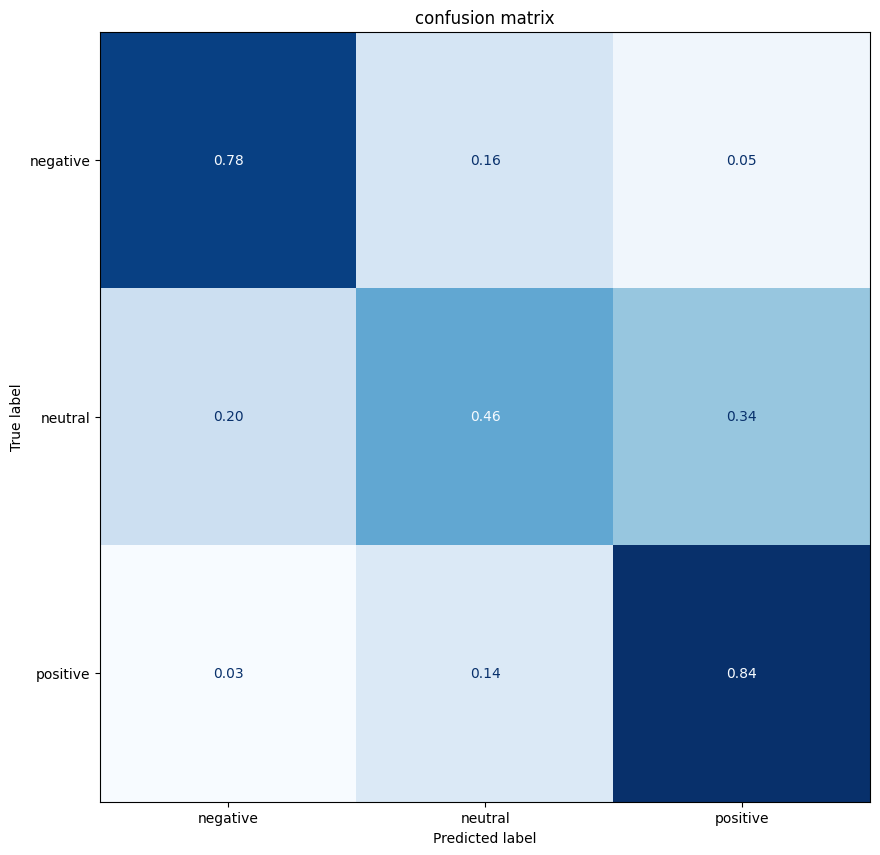

In [55]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

## Validation

In [56]:
y_valid = np.array(validation_dataset["labels"])
preds_output = trainer.predict(validation_dataset)

In [57]:
preds_output.metrics

{'test_loss': 0.7056845426559448,
 'test_accuracy': 0.7071428571428572,
 'test_f1': 0.6860755492334439,
 'test_precision': 0.6864782715846546,
 'test_recall': 0.6857732732732732,
 'test_runtime': 2.3348,
 'test_samples_per_second': 59.963,
 'test_steps_per_second': 1.713}

In [58]:
y_preds = np.argmax(preds_output.predictions, axis=1)

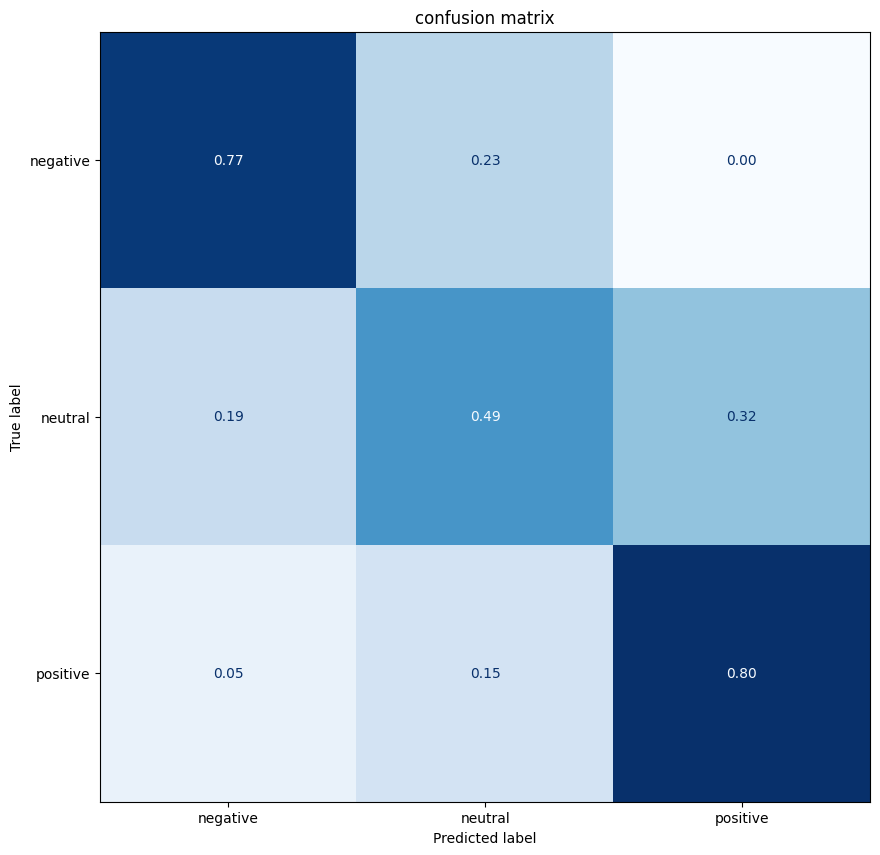

In [59]:
labels = train_dataset.features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

In [50]:
%%notify
import time
time.sleep(1)

<IPython.core.display.Javascript object>